In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-05-15 20:53:24
# @Last Modified: 2024-05-15 21:00:21
# ------------------------------------------------------------------------------ #
# This notebook does the model comparison and creates the panel for fig. 2.
# it needs the idata traces from `bayesian_analysis.ipynb`
# Preprocessing / Setup in the first cell is the same in both notebooks.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
extra_path = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat"


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2024-05-17 09:19:25,467 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [3]:
# Lets start with a bit of exploration:
# linear model
idata_lm = az.from_netcdf(f"{data_dir}/lm_tau_R_natural_movie_three.nc")
# structure group model
idata_sgm = az.from_netcdf(f"{data_dir}/sgm_tau_R_natural_movie_three.nc")
idata_sgm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [4]:
idata_lm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [5]:
comparison = az.compare(
    {"linear model": idata_lm, "structure groups": idata_sgm},
)
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
structure groups,0,-8280.903231,76.219932,0.000000,0.8859,83.587912,0.000000,False,log
linear model,1,-8538.728451,44.002545,257.825219,0.1141,72.114252,27.746184,False,log


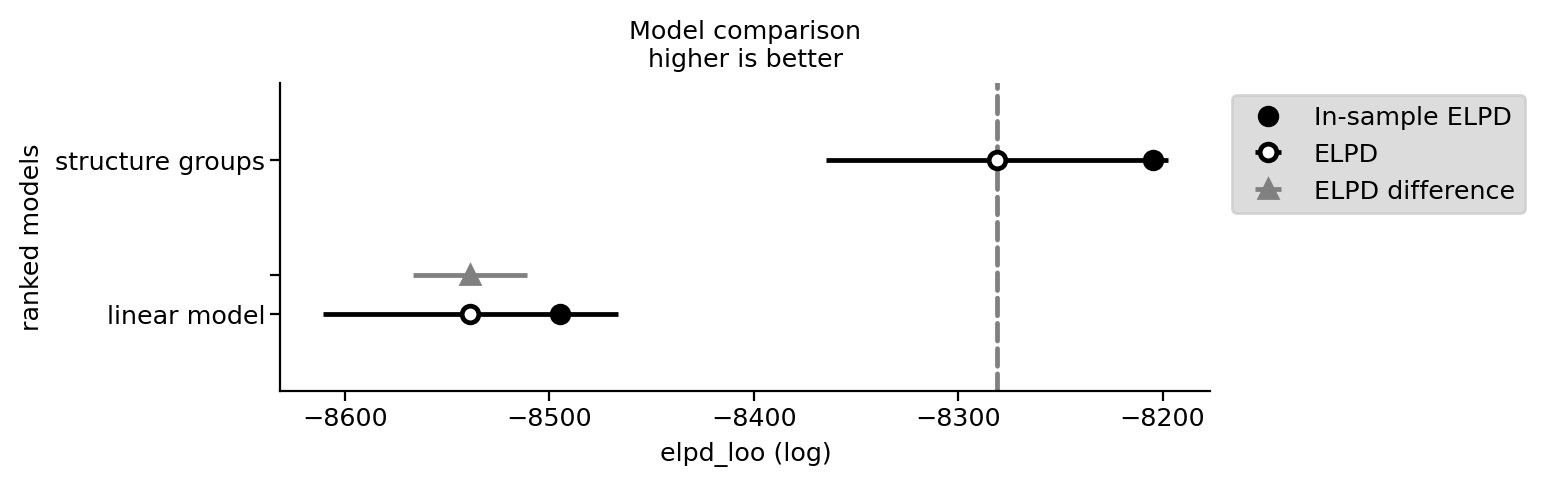

In [6]:
az.plot_compare(comparison, insample_dev=True, plot_ic_diff=True, plot_standard_error=True);

In [18]:
comparison["elpd_loo"]

structure groups   -8280.903231
linear model       -8558.818998
Name: elpd_loo, dtype: float64

In [19]:
loo_lm = az.loo(idata_lm, pointwise=True)
loo_sgm = az.loo(idata_sgm, pointwise=True)

In [29]:
obs = 'loo_i'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs]).values}")
print(f"sgm: {np.sum(loo_sgm[obs]).values}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff {np.sum(diff).values}")
print(f"se: {np.sqrt(len(diff) * np.var(diff)).values}")

shape: (6256,)
lm: -8558.81899810318
sgm: -8280.90323121093
diff -277.9157668922502
se: 26.880775172556003


In [28]:
len(loo_sgm['loo_i'].values)

6256

In [26]:
np.sum(loo_sgm['loo_i'].values - loo_lm['loo_i'].values)

277.9157668922502

In [34]:
obs = 'elpd_loo'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs])}")
print(f"sgm: {np.sum(loo_sgm[obs])}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff {np.mean(diff)}")

shape: ()
lm: -21644.901937838375
sgm: -21349.392344066167
diff -295.50959377220715


In [7]:
from itertools import product
from tqdm.notebook import tqdm

models = ['sgm', 'lm']
measures = ["R_tot", "tau_R", "tau_double"]
stimuli = ["natural_movie_three", "spontaneous", "natural_movie_one_more_repeats"]

combinations = list(product(measures, stimuli, models))
loos = dict()

for meas, stim, model in tqdm(combinations):
    idata = az.from_netcdf(f"{data_dir}/{model}_{meas}_{stim}.nc")
    loos[f"{model}_{meas}_{stim}"] = az.loo(idata, pointwise=True)

  0%|          | 0/18 [00:00<?, ?it/s]

['tau_C', 'tau_R', 'R_tot']


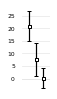

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bitsandbobs.plt import set_size

# FPS: The other panesl are quite big and we downscale them to ~60%.
# Here I used native / real-life units (100%), with font sizes ~8pt and 6pt.
fig, ax = plt.subplots(figsize=(4,3))

matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)  # transparent figure bg
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["xtick.labelsize"]= 6
matplotlib.rcParams["ytick.labelsize"]= 6


# stim = "spontaneous"
stim = "natural_movie_three"
stim = "natural_movie_one_more_repeats"

for mdx, meas in enumerate(measures):
    # this is the same what arviz.compare does, but
    # I decided to not use az.compare because it ranks the models, but we always want
    # to have "structure_groups - linear_model".
    # 'loo_i' gives us the array of the leave-one-out samples, with length rows in df
    diff = (
        loos[f"lm_{meas}_{stim}"]["loo_i"]
        - loos[f"sgm_{meas}_{stim}"]["loo_i"]
    )
    ax.errorbar(
        x=mdx + 1,
        y=np.sum(diff),
        yerr=np.sqrt(len(diff) * np.var(diff)),
        label=f"{meas}",
        fmt = "s",
        # markeredgewidth = 0.0,
        markersize = 3.0,
        markerfacecolor = 'white',
        ecolor = 'black',
        color = "black",
        elinewidth = 1.2,
        capsize = 2,
        clip_on=False,
    )

ax.set_xticks([])
# ax.set_ylim(-28, 5)
# yticks = [-25, -20, -15, -10, -5, 0]
yticks = [25, 20, 15, 10, 5, 0]
ax.set_yticks(yticks)
for y in yticks:
    ax.axhline(y, ls="-", lw=1.0 if y == 0 else 0.7, zorder=0, color="#E6E6E6")
ax.set_xlim(0, 4)
sns.despine(ax=ax, trim=False, bottom=True)
# ax.set_ylabel("ELPD difference")
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
print(measures)

set_size(ax, w=1.0, h=3.0, b=0.1, l=0.7, t=0.1)
# ax.get_figure().savefig(f"../img/model_comparison_{stim}_all_measures.pdf")